## Requirements

### Imports

In [367]:
import os
import torch
from pathlib import Path

import random
import torch
import torchcam
import matplotlib.pyplot as plt
import numpy as np
import cv2

from torchcam.methods import GradCAM
from torchvision import transforms

In [368]:
import training

In [369]:
torch.manual_seed(42)

### Paths

In [370]:
SRC_DIR = Path.cwd()
ROOT_DIR = SRC_DIR.parent

DATA_DIR = os.path.join(ROOT_DIR, 'dataset')
PREPROCESSED_DIR = os.path.join(DATA_DIR, 'preprocessed')
CSV_PATH = os.path.join(DATA_DIR, 'csv_mappings', 'train.csv')

MODEL_DIR = os.path.join(ROOT_DIR, 'models')
BASELINE_DIR = os.path.join(MODEL_DIR, 'baselines')
BASELINE_FINETUNED_DIR = os.path.join(MODEL_DIR, 'baselines_finetuned')
RESULT_DIR = os.path.join(BASELINE_DIR, 'results')

### Load Data

In [371]:
BATCH_SIZE = 32

In [372]:
CLASS_NAMES = {
    0: "amanita",
    1: "boletus",
    2: "chantelle",
    3: "deterrimus",
    4: "rufus",
    5: "torminosus",
    6: "aurantiacum",
    7: "procera",
    8: "involutus",
    9: "russula"
}

In [373]:
train_loader, val_loader, test_loader = training.get_data_loaders(PREPROCESSED_DIR, CSV_PATH, BATCH_SIZE)

### Set model to explain

In [374]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_CLASSES = 10 

In [375]:
model_type = 'custom_resnet'  
# alexnet # resnet # vgg16 # densenet # efficientnet
# custom_alexnet custom_resnet

In [376]:
model = training.load_model_for_explaining(model_type, NUM_CLASSES, DEVICE, finetuned=True)

c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model 'custom_resnet' loaded successfully from c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\models\baselines_finetuned\custom_resnet\results\custom_resnet.pth


c:\Users\ilian\Documents\Projects\git_projects\university\mushroom_classification\src\training.py:412: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(

### Explain Functions

In [75]:
def unnormalize(image_tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(image_tensor, mean, std):
        t.mul_(s).add_(m)
    return image_tensor

def show_random_image(test_loader, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    random_index = random.randint(0, len(test_loader.dataset) - 1)
    image, label = test_loader.dataset[random_index]
    image = unnormalize(image.clone(), mean, std)
    original_image = image.cpu().numpy().transpose(1, 2, 0)

    plt.imshow(original_image)
    plt.title("Original Image")
    plt.axis('off')
    plt.show()
    
    return image, label

In [76]:
def integrated_gradients(model, image, target_class, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(image)
    
    interpolated_images = [(baseline + (float(i) / steps) * (image - baseline)) for i in range(steps + 1)]
    interpolated_images = torch.stack(interpolated_images).to(image.device)
    interpolated_images = interpolated_images.squeeze(1)
    
    batch_size = interpolated_images.shape[0]
    interpolated_images = interpolated_images.view(batch_size, 3, 224, 224)

    interpolated_images.requires_grad = True
    model.zero_grad()
    
    outputs = model(interpolated_images)
    target = outputs[:, target_class]
    target.backward(torch.ones_like(target), retain_graph=True)

    gradients = interpolated_images.grad
    integrated_gradients = (image - baseline) * gradients.mean(dim=0)
    
    return integrated_gradients

In [77]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_integrated_gradients(model, image, label, integrated_gradients_func, device):
    image_tensor = image.unsqueeze(0).to(device)
    target_class = label.item()

    attributions = integrated_gradients_func(model, image_tensor, target_class)
    attributions = attributions.squeeze().cpu().numpy()
    attributions = np.abs(attributions)

    attributions_min = np.min(attributions)
    attributions_max = np.max(attributions)
    attributions = (attributions - attributions_min) / (attributions_max - attributions_min)

    original_image = image.cpu().numpy().transpose(1, 2, 0)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis('off')

    # Attribution maps for (R, G, B)
    for i, ax in enumerate(axes[1:]):
        ax.imshow(attributions[i], cmap='hot')
        ax.set_title(f'Channel {i+1} Attribution')
        ax.axis('off')

    plt.show()


### Images to explain

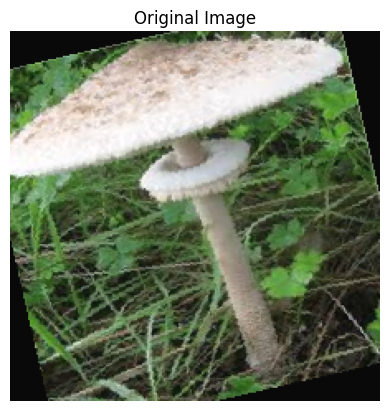

In [197]:
image1, label1 = show_random_image(test_loader)

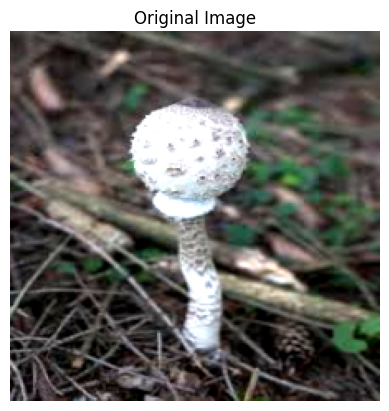

In [170]:
image2, label2 = show_random_image(test_loader)

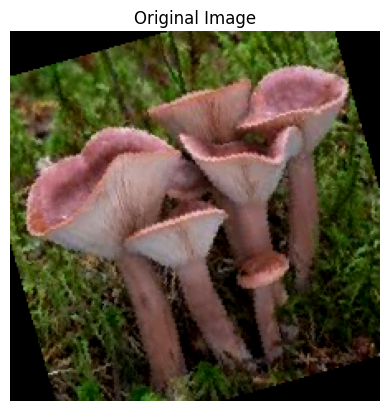

In [172]:
image3, label3 = show_random_image(test_loader)

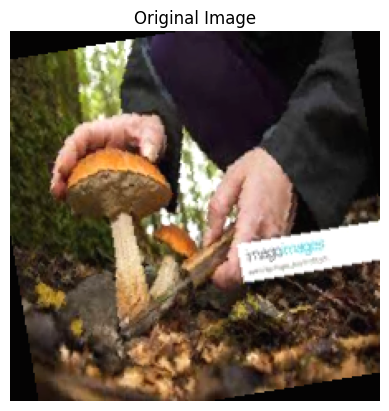

In [176]:
image4, label4 = show_random_image(test_loader)

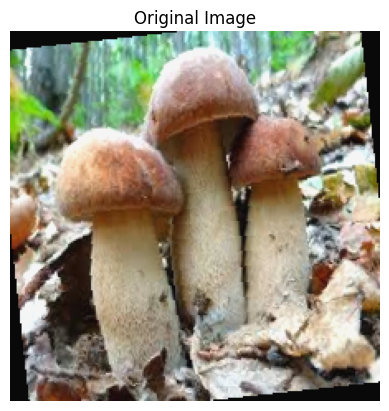

In [193]:
image5, label5 = show_random_image(test_loader)

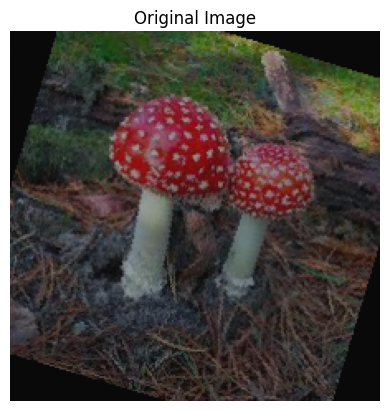

In [207]:
image6, label6 = show_random_image(test_loader)

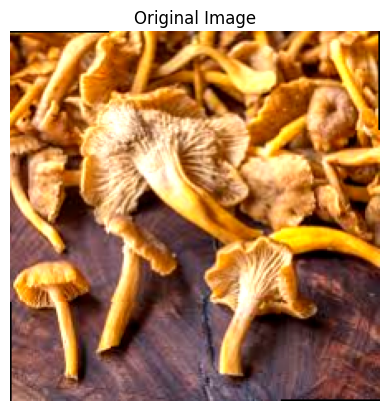

In [209]:
image7, label7 = show_random_image(test_loader)

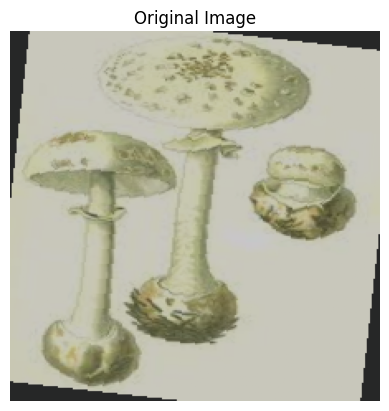

In [294]:
image8, label8 = show_random_image(test_loader)

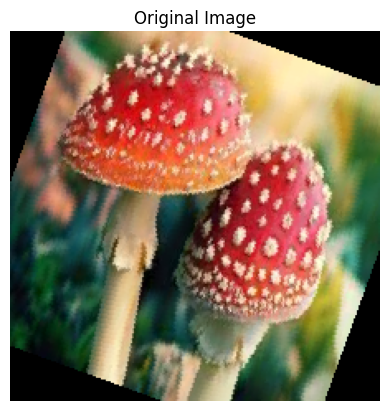

In [364]:
image9, label9 = show_random_image(test_loader)

### Apply

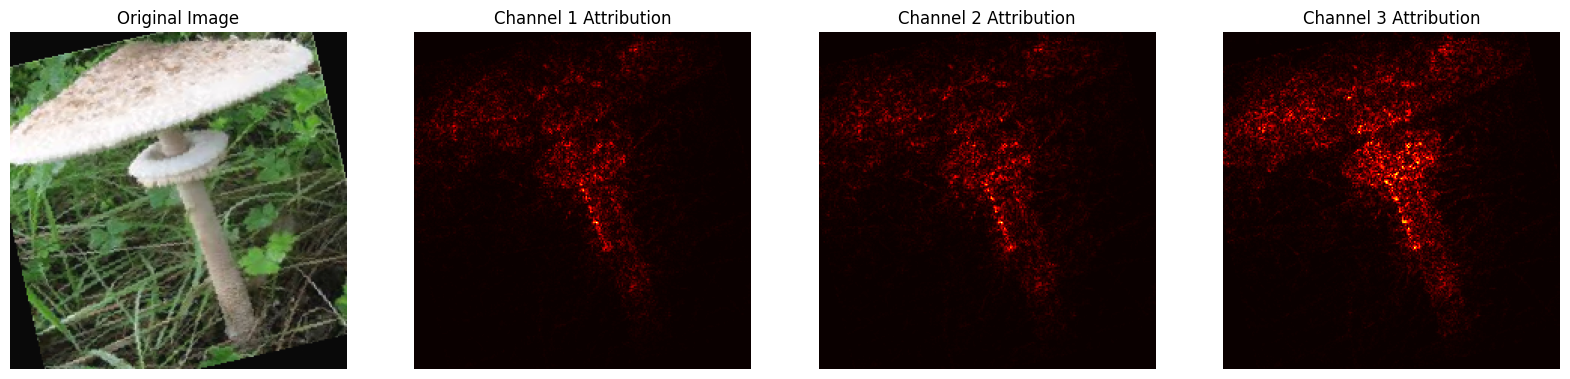

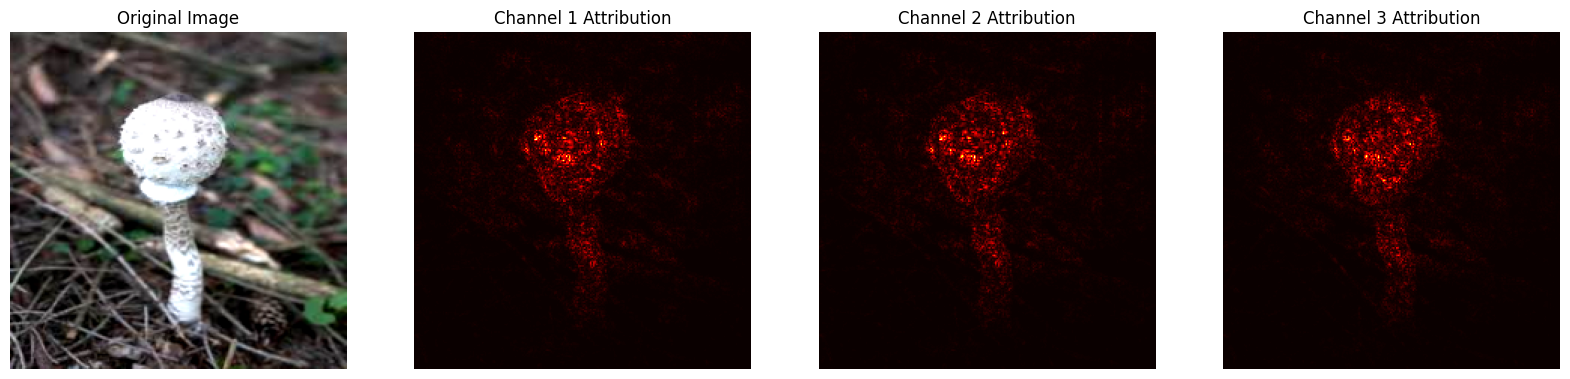

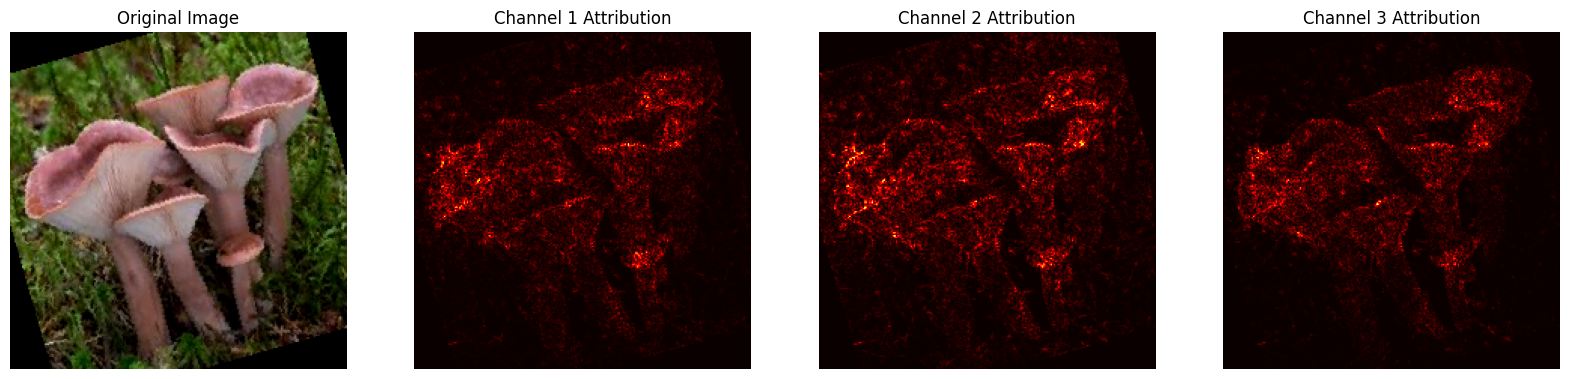

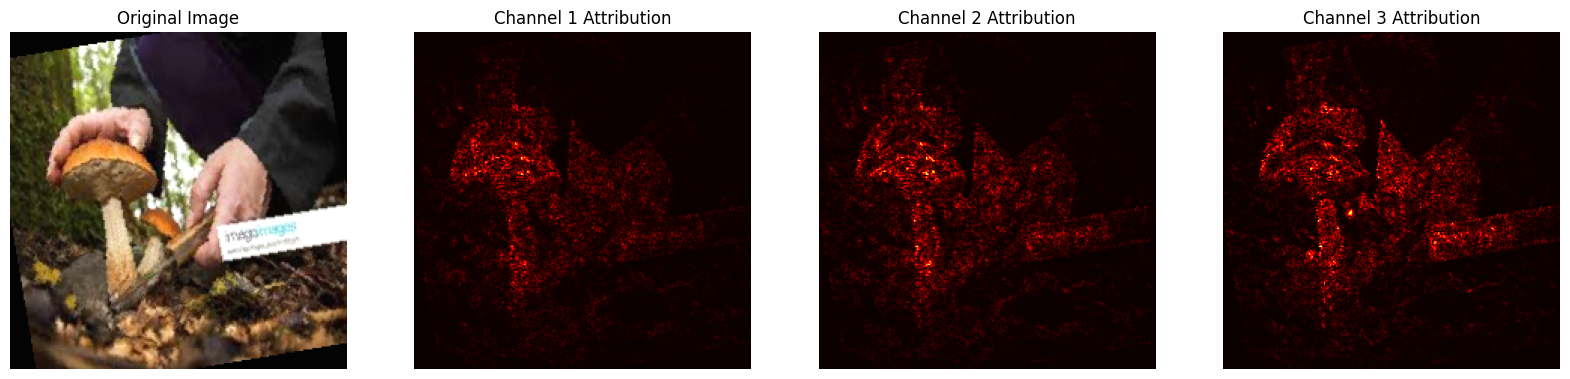

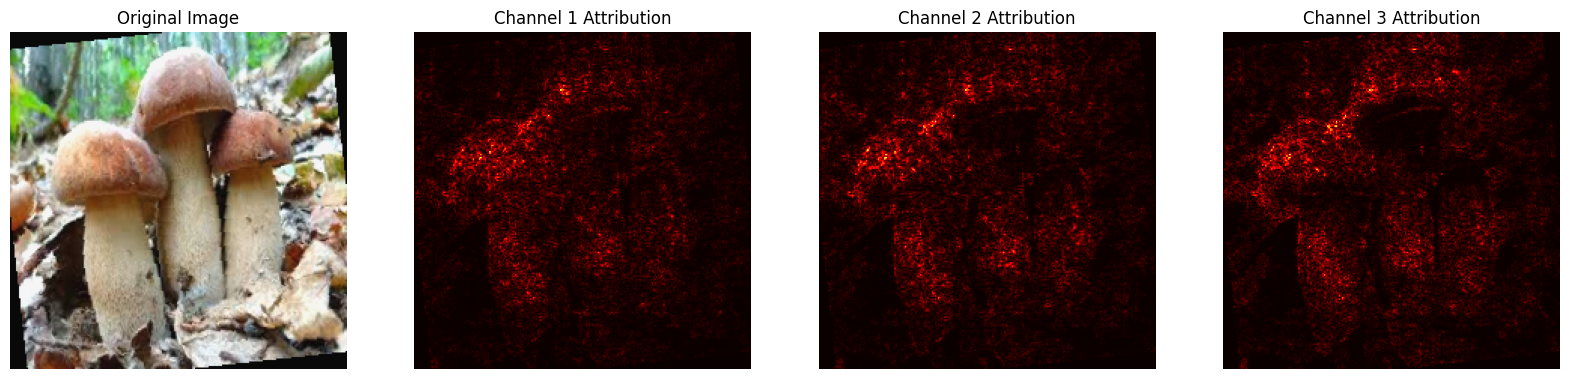

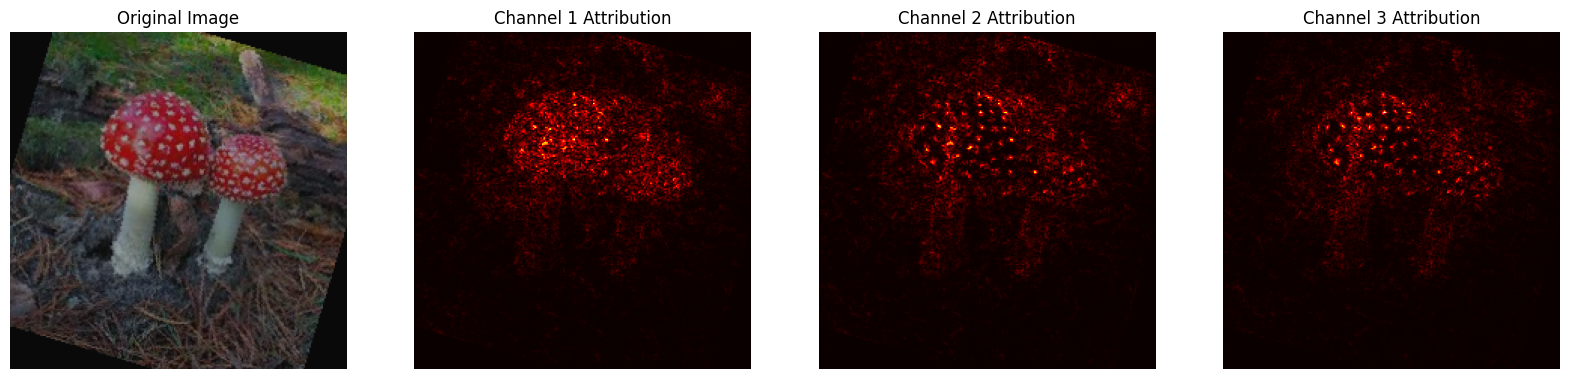

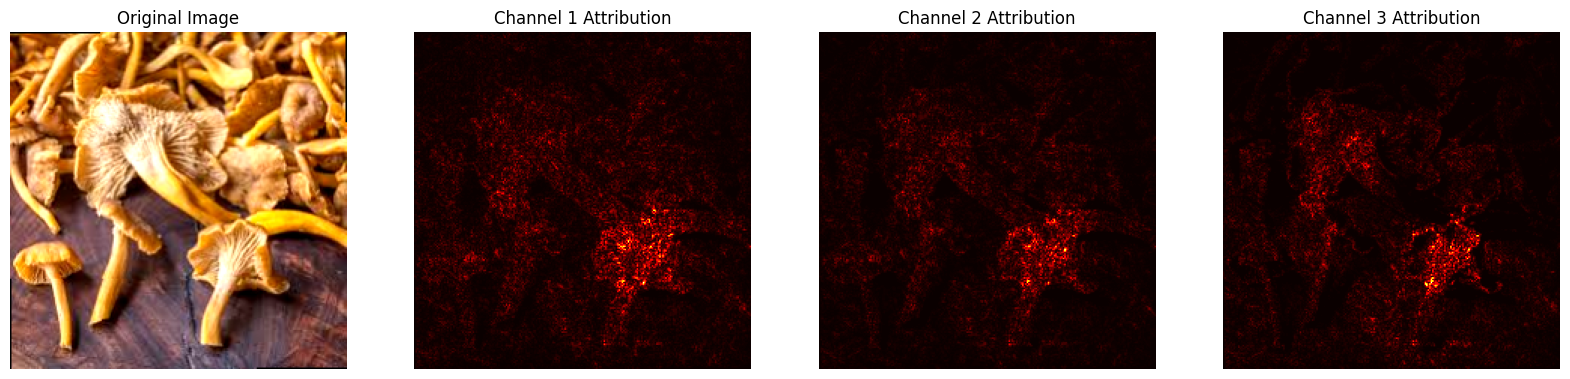

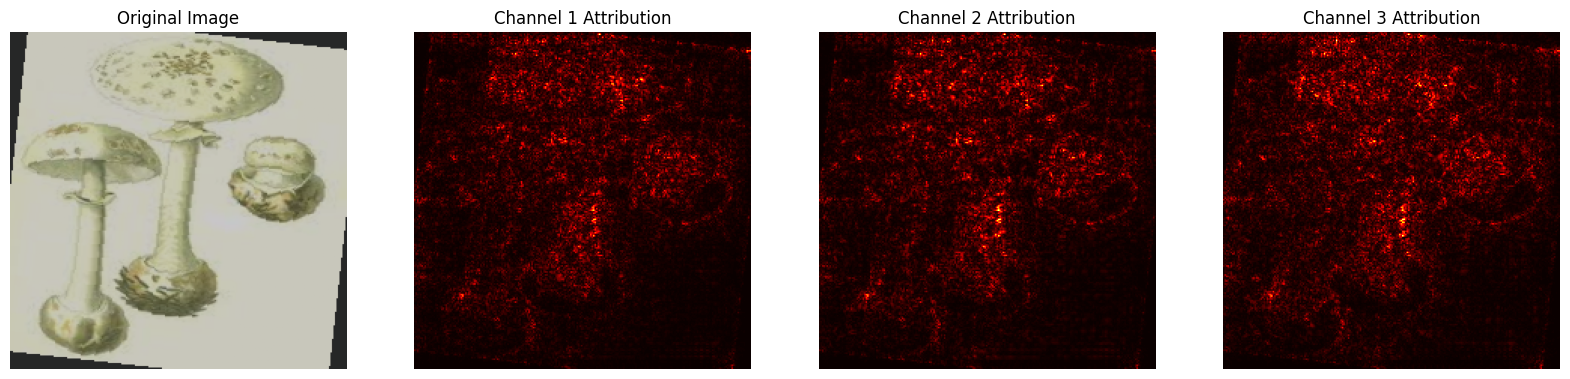

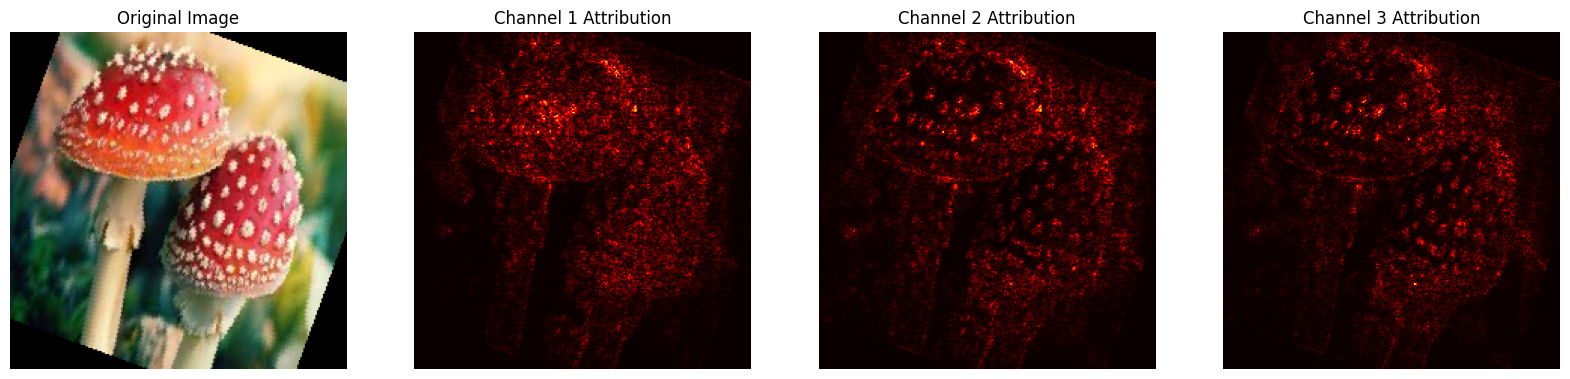

In [377]:
image_label_pairs = [(image1, label1), (image2, label2), (image3, label3), 
                     (image4, label4), (image5, label5), (image6, label6),
                     (image7, label7), (image8, label8), (image9, label9)]

for image, label in image_label_pairs:
    visualize_integrated_gradients(model, image, label, integrated_gradients, DEVICE)
